In [1]:
import math
import tqdm
import itertools
import copy
import types
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
# PyTorch
import torch
torch.manual_seed(42)
import gpytorch

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import losses
import utils

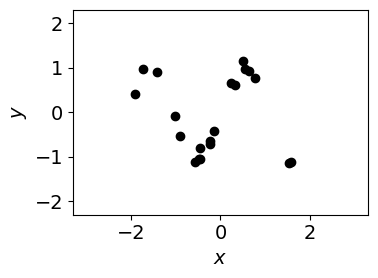

In [3]:
N = 20
random_state = np.random.RandomState(42)
X_numpy = random_state.randn(N, 1)
y_numpy = np.sin(3 * X_numpy) + 0.1 * random_state.randn(N, 1)

X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float32)

X_train, X_val = X[:int((4/5)*N)], X[int((4/5)*N):]
y_train, y_val = y[:int((4/5)*N)], y[int((4/5)*N):]

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_numpy, y_numpy, color='#000000')
ax.set_xlim([-3.3, 3.3])
ax.set_ylim([-2.3, 2.3])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [4]:
def train_one_epoch(model, criterion, optimizer, X, y, num_samples=1):
    model.train()
    optimizer.zero_grad()
    
    avg_metrics = {}
    for _ in range(num_samples):
        
        logits = model(X)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params, len(X))
        metrics['loss'].backward()
        
        for key, value in metrics.items():
            avg_metrics.setdefault(key, 0.0)
            avg_metrics[key] += (1/num_samples) * value.item()
        
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data.mul_(1/num_samples)

    optimizer.step()
    return avg_metrics

def evaluate(model, criterion, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params, len(X))
    return metrics

In [5]:
model = layers.RandomFeatureGaussianProcess(in_features=1, out_features=1, lengthscale=1.0)
init_state_dict = copy.deepcopy(model.state_dict())

criterion = losses.ERMLoss(criterion=torch.nn.MSELoss())

best_state_dict = None
best_metric = np.inf

for lr, outputscale in itertools.product([0.1, 0.01, 0.001, 0.0001], [10.0, 1.0, 0.1, 0.01, 0.001]):
   
    model.load_state_dict(init_state_dict)
    model.outputscale_param = torch.log(torch.expm1(torch.tensor(outputscale)))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X_train, y_train)

    val_metrics = evaluate(model, criterion, X_val, y_val)
    if val_metrics['nll'] < best_metric:
        best_state_dict = copy.deepcopy(model.state_dict())
        best_metric = val_metrics['nll']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000).view(-1, 1)
    lengthscale1_preds = model(linspace)
    torch.save(lengthscale1_preds, 'regression_lengthscale1_preds.pt')

100%|██████████| 10000/10000 [00:09<00:00, 1073.83it/s]


In [6]:
model = layers.RandomFeatureGaussianProcess(in_features=1, out_features=1, lengthscale=20.0)
init_state_dict = copy.deepcopy(model.state_dict())

criterion = losses.ERMLoss(criterion=torch.nn.MSELoss())

best_state_dict = None
best_metric = np.inf

for lr, outputscale in itertools.product([0.1, 0.01, 0.001, 0.0001], [10.0, 1.0, 0.1, 0.01, 0.001]):
   
    model.load_state_dict(init_state_dict)
    model.outputscale_param = torch.log(torch.expm1(torch.tensor(outputscale)))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X_train, y_train)

    val_metrics = evaluate(model, criterion, X_val, y_val)
    if val_metrics['nll'] < best_metric:
        best_state_dict = copy.deepcopy(model.state_dict())
        best_metric = val_metrics['nll']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000).view(-1, 1)
    lengthscale2_preds = model(linspace)
    torch.save(lengthscale2_preds, 'regression_lengthscale2_preds.pt')

100%|██████████| 10000/10000 [00:09<00:00, 1011.64it/s]


In [7]:
model = layers.RandomFeatureGaussianProcess(in_features=1, out_features=1, learnable_lengthscale=True, learnable_noise=True, learnable_outputscale=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
init_state_dict = copy.deepcopy(model.state_dict())

#criterion = losses.KappaELBoLoss(1.0, model.sigma_param, criterion=torch.nn.MSELoss())
criterion = losses.KappaELBoLoss(1.0, model.sigma_param, criterion=model.gaussian_nll_loss)

best_state_dict = None
best_metric = np.inf

for lr in [0.1, 0.01, 0.001, 0.0001]:
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X, y, 5)

    if train_metrics['loss'] < best_metric:
        best_state_dict = copy.deepcopy(model.state_dict())
        best_metric = train_metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000).view(-1, 1)
    elbo_mean = model(linspace)
    model.use_posterior(True)
    #elbo_samples = torch.stack([model(linspace).view(-1) for _ in range(100)])
    elbo_samples = torch.stack([model(linspace).view(-1) + model.noise * torch.randn((1000,)) for _ in range(10_000)])
    torch.save(elbo_mean, 'regression_elbo_mean.pt')
    torch.save(elbo_samples, 'regression_elbo_samples.pt')

100%|██████████| 10000/10000 [01:49<00:00, 90.92it/s]


In [8]:
model = layers.RandomFeatureGaussianProcess(in_features=1, out_features=1, learnable_lengthscale=True, learnable_noise=True, learnable_outputscale=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
init_state_dict = copy.deepcopy(model.state_dict())

#criterion = losses.KappaELBoLoss(len(utils.flatten_params(model))/len(X), model.sigma_param, criterion=torch.nn.MSELoss())
criterion = losses.KappaELBoLoss(len(utils.flatten_params(model))/len(X), model.sigma_param, criterion=model.gaussian_nll_loss)

best_state_dict = None
best_metric = np.inf

for lr in [0.1, 0.01, 0.001, 0.0001]:
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X, y, 5)

    if train_metrics['loss'] < best_metric:
        best_state_dict = copy.deepcopy(model.state_dict())
        best_metric = train_metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000).view(-1, 1)
    de_elbo_mean = model(linspace)
    model.use_posterior(True)
    #de_elbo_samples = torch.stack([model(linspace).view(-1) for _ in range(100)])
    de_elbo_samples = torch.stack([model(linspace).view(-1) + model.noise * torch.randn((1000,)) for _ in range(10_000)])
    torch.save(de_elbo_mean, 'regression_de_elbo_mean.pt')
    torch.save(de_elbo_samples, 'regression_de_elbo_samples.pt')

100%|██████████| 10000/10000 [04:04<00:00, 40.84it/s]


In [9]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones((N,)))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, y.view(-1), likelihood)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

for epoch in tqdm.tqdm(range(10_000)):
    optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y.view(-1)).sum()
    loss.backward()
    optimizer.step()

model.eval()
likelihood.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000)
    gp_preds = likelihood(model(linspace))
    gp_samples = gp_preds.sample(torch.Size((3,)))
    torch.save(gp_preds, 'regression_gp_preds.pt')
    torch.save(gp_samples, 'regression_gp_samples.pt')

100%|██████████| 10000/10000 [01:17<00:00, 129.20it/s]


In [10]:
lengthscale1_preds = torch.load('regression_lengthscale1_preds.pt', weights_only=False)
lengthscale2_preds = torch.load('regression_lengthscale2_preds.pt', weights_only=False)
elbo_mean = torch.load('regression_elbo_mean.pt', weights_only=False)
elbo_samples = torch.load('regression_elbo_samples.pt', weights_only=False)
de_elbo_mean = torch.load('regression_de_elbo_mean.pt', weights_only=False)
de_elbo_samples = torch.load('regression_de_elbo_samples.pt', weights_only=False)
gp_preds = torch.load('regression_gp_preds.pt', weights_only=False)
gp_samples = torch.load('regression_gp_samples.pt', weights_only=False)

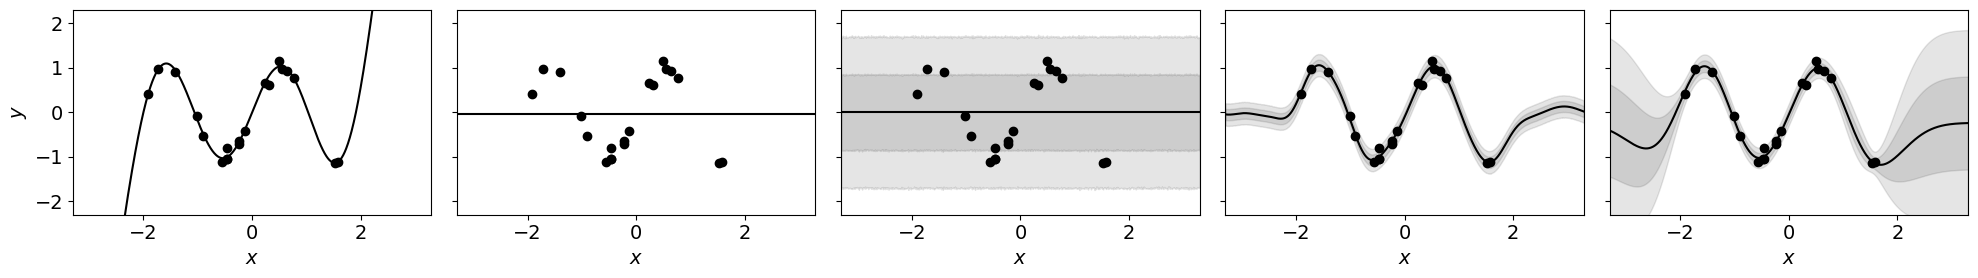

In [11]:
linspace = np.linspace(start=-3.3, stop=3.3, num=1000)

ncols, nrows = 5, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')

axs[0].scatter(X_numpy, y_numpy, color='#000000')
axs[0].plot(linspace, lengthscale1_preds, color='#000000')
axs[0].set_xlim([-3.3, 3.3])
axs[0].set_ylim([-2.3, 2.3])
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$y$')

axs[1].scatter(X_numpy, y_numpy, color='#000000')
axs[1].plot(linspace, lengthscale2_preds, color='#000000')
axs[1].set_xlim([-3.3, 3.3])
axs[1].set_ylim([-2.3, 2.3])
axs[1].set_xlabel(r'$x$')

axs[2].scatter(X_numpy, y_numpy, color='#000000')
axs[2].fill_between(linspace, elbo_samples.mean(dim=0)+2*elbo_samples.std(dim=0), elbo_samples.mean(dim=0)-2*elbo_samples.std(dim=0), alpha=0.1, color='#000000')
axs[2].fill_between(linspace, elbo_samples.mean(dim=0)+1*elbo_samples.std(dim=0), elbo_samples.mean(dim=0)-1*elbo_samples.std(dim=0), alpha=0.1, color='#000000')
#axs[2].plot(linspace, elbo_samples[0], color='#D62728')
#axs[2].plot(linspace, elbo_samples[1], color='#1F77B4')
#axs[2].plot(linspace, elbo_samples[2], color='#2CA02C')
axs[2].plot(linspace, elbo_mean, color='#000000')
axs[2].set_xlim([-3.3, 3.3])
axs[2].set_ylim([-2.3, 2.3])
axs[2].set_xlabel(r'$x$')

axs[3].scatter(X_numpy, y_numpy, color='#000000')
axs[3].fill_between(linspace, de_elbo_samples.mean(dim=0)+2*de_elbo_samples.std(dim=0), de_elbo_samples.mean(dim=0)-2*de_elbo_samples.std(dim=0), alpha=0.1, color='#000000')
axs[3].fill_between(linspace, de_elbo_samples.mean(dim=0)+1*de_elbo_samples.std(dim=0), de_elbo_samples.mean(dim=0)-1*de_elbo_samples.std(dim=0), alpha=0.1, color='#000000')
#axs[3].plot(linspace, de_elbo_samples[0], color='#D62728')
#axs[3].plot(linspace, de_elbo_samples[1], color='#1F77B4')
#axs[3].plot(linspace, de_elbo_samples[2], color='#2CA02C')
axs[3].plot(linspace, de_elbo_mean, color='#000000')
axs[3].set_xlim([-3.3, 3.3])
axs[3].set_ylim([-2.3, 2.3])
axs[3].set_xlabel(r'$x$')

axs[4].scatter(X_numpy, y_numpy, color='#000000')
axs[4].fill_between(linspace, gp_preds.mean+2*gp_preds.stddev, gp_preds.mean-2*gp_preds.stddev, alpha=0.1, color='#000000')
axs[4].fill_between(linspace, gp_preds.mean+1*gp_preds.stddev, gp_preds.mean-1*gp_preds.stddev, alpha=0.1, color='#000000')
#axs[4].plot(linspace, gp_samples[0], color='#D62728')
#axs[4].plot(linspace, gp_samples[1], color='#1F77B4')
#axs[4].plot(linspace, gp_samples[2], color='#2CA02C')
axs[4].plot(linspace, gp_preds.mean, color='#000000')
axs[4].set_xlim([-3.3, 3.3])
axs[4].set_ylim([-2.3, 2.3])
axs[4].set_xlabel(r'$x$')

fig.tight_layout()
fig.savefig('regression_demo.pdf', bbox_inches='tight')
plt.show()